In [2]:
# 1. Install Kaggle and setup
!pip install -q kaggle

# 2. Create and write kaggle.json credentials from string
import os
kaggle_token = {
    "username":"your_kaggle_username_here",
    "key":"your_kaggle_api_key_here"
}

# Save to kaggle.json
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    import json
    json.dump(kaggle_token, f)

# 3. Set file permissions
!chmod 600 /root/.kaggle/kaggle.json

# 4. Download Kube-IDS0 Dataset from Kaggle
!kaggle datasets download -d redamorsli/kube-ids0

# 5. Unzip it into dataset folder
!unzip -q kube-ids0.zip -d dataset

# 6. Check files
print("Dataset downloaded and ready:")
!ls -R dataset

Dataset URL: https://www.kaggle.com/datasets/redamorsli/kube-ids0
License(s): unknown
 82% 350M/429M [00:00<00:00, 644MB/s] 
100% 429M/429M [00:06<00:00, 73.8MB/s]
Dataset downloaded and ready:
dataset:
boa_dataset  dvwa_dataset

dataset/boa_dataset:
processed  raw

dataset/boa_dataset/processed:
 1-network_flows	   '3-merged(slowloris+torshammer)'
'2-merged(net+container)'   boa_dataset_ml_ready_frontend_microservice.csv

dataset/boa_dataset/processed/1-network_flows:
benign+slowloris_net_flows.csv	benign+torshammer_net_flows.csv

'dataset/boa_dataset/processed/2-merged(net+container)':
slowloris_merged_dimensions_frontend_microservice.csv
torshammer_merged_dimensions_frontend_microservice.csv

'dataset/boa_dataset/processed/3-merged(slowloris+torshammer)':
boa_merged_not_cleaned_frontend_microservice.csv

dataset/boa_dataset/raw:
container_metrics  network_captures

dataset/boa_dataset/raw/container_metrics:
benign+slowloris_container_metrics.csv	benign+torshammer_container_metrics.c

## **Data Loading and Inspection**

In [3]:
import pandas as pd

# path to main dataset file
data_path = "dataset/boa_dataset/processed/boa_dataset_ml_ready_frontend_microservice.csv"

# load data
df = pd.read_csv(data_path)

# show shape of dataset
print("Shape of dataset:", df.shape)

# show first 5 rows
print(df.head())

# show column names
print("Column names:", df.columns.tolist())

# check label column and value counts
label_column = None
for col in ["label", "class", "target", "attack_type"]:
    if col in df.columns:
        label_column = col
        break

if label_column:
    print(f"Label column found: {label_column}")
    print(df[label_column].value_counts())
else:
    print("No common label column found. Please check columns.")

Shape of dataset: (10069, 225)
   packets_count  fwd_packets_count  bwd_packets_count  total_payload_bytes  \
0             19                  9                 10                10107   
1              4                  2                  2                 4689   
2             56                 30                 26                67156   
3             48                 19                 29               126612   
4             15                  7                  8                 6245   

   fwd_total_payload_bytes  bwd_total_payload_bytes  payload_bytes_max  \
0                     1007                     9100               2914   
1                     4641                       48               4641   
2                      840                    66316               8254   
3                     7708                   118904              12401   
4                      155                     6090               1974   

   payload_bytes_mean  payload_bytes_std  payload

## **Exploratory Data Analysis (EDA)**

Total missing values in dataset: 0
Missing values per column (top 10):
Series([], dtype: int64)

Basic statistics:
                           count          mean           std  min  25%  50%  \
packets_count            10069.0  1.616347e+01  5.577881e+01  1.0  2.0  2.0   
fwd_packets_count        10069.0  8.406793e+00  3.244756e+01  0.0  1.0  1.0   
bwd_packets_count        10069.0  7.756679e+00  2.360166e+01  0.0  1.0  1.0   
total_payload_bytes      10069.0  2.392706e+04  8.226498e+04  0.0  0.0  0.0   
fwd_total_payload_bytes  10069.0  2.843365e+03  1.733558e+04  0.0  0.0  0.0   
bwd_total_payload_bytes  10069.0  2.108370e+04  7.935966e+04  0.0  0.0  0.0   
payload_bytes_max        10069.0  1.614908e+03  4.199920e+03  0.0  0.0  0.0   
payload_bytes_mean       10069.0  3.469651e+02  8.512701e+02  0.0  0.0  0.0   
payload_bytes_std        10069.0  5.008230e+02  1.196298e+03  0.0  0.0  0.0   
payload_bytes_variance   10069.0  1.681811e+06  5.947097e+06  0.0  0.0  0.0   

               

/tmp/ipython-input-1484005163.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


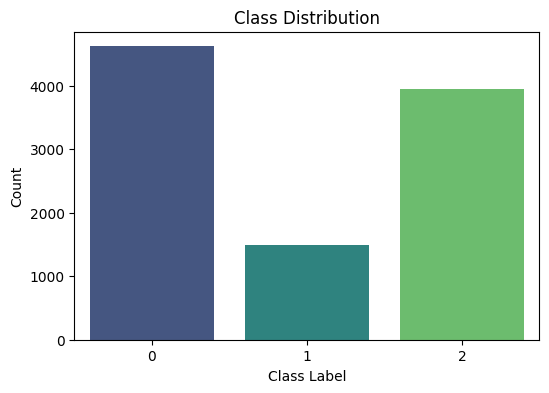

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# check missing values
missing_values = df.isnull().sum()
missing_total = missing_values.sum()
print("Total missing values in dataset:", missing_total)
print("Missing values per column (top 10):")
print(missing_values[missing_values > 0].sort_values(ascending=False).head(10))

# basic statistics
print("\nBasic statistics:")
print(df.describe().T.head(10))

# plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

## **Preprocessing and CNN + LSTM**

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# separate features and labels
X = df.drop(columns=["label"])
y = df["label"]

# one-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y
)

# reshape for CNN + LSTM (timesteps=1 for now, features=number of columns)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8055, 1, 224)
X_test shape: (2014, 1, 224)
y_train shape: (8055, 3)
y_test shape: (2014, 3)


## **Building Hybrid model**

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model

# transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # multi-head self attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # feed-forward network
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1], activation="linear")(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# model input
inp = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN layer
x = Conv1D(filters=64, kernel_size=1, activation='relu')(inp)

# LSTM layer
x = LSTM(64, return_sequences=True)(x)

# Transformer block
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

# flatten and dense
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# output layer
out = Dense(y_train.shape[1], activation='softmax')(x)

# model definition
model = Model(inputs=inp, outputs=out)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 224)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 64)     │     14,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     33,024 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     66,368 │ lstm[0][0],       │
│ (MultiHeadAttentio… │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 64)     │        128 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 128)    │      8,320 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 128)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 64)     │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,979 (527.26 KB)

 Trainable params: 134,979 (527.26 KB)

 Non-trainable params: 0 (0.00 B)

# **Training and Evaluation CNN + LSTM**

In [7]:
# early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

# callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9448 - loss: 0.1728 - val_accuracy: 0.9975 - val_loss: 0.0161
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9976 - loss: 0.0159 - val_accuracy: 0.9975 - val_loss: 0.0094
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9978 - loss: 0.0161 - val_accuracy: 0.9975 - val_loss: 0.0188
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9963 - loss: 0.0155 - val_accuracy: 0.9981 - val_loss: 0.0136
Epoch 5/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9986 - loss: 0.0098 - val_accuracy: 0.9975 - val_loss: 0.0123
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9938 - val_loss: 0.0345
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9961 - loss: 0.0254 - val_accuracy: 0.9981 - val_loss: 0.0090
Epoch 8/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9982 - loss: 0.0097 - val_accuracy:

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       924
           1       0.99      1.00      0.99       299
           2       1.00      1.00      1.00       791

    accuracy                           1.00      2014
   macro avg       1.00      1.00      1.00      2014
weighted avg       1.00      1.00      1.00      2014



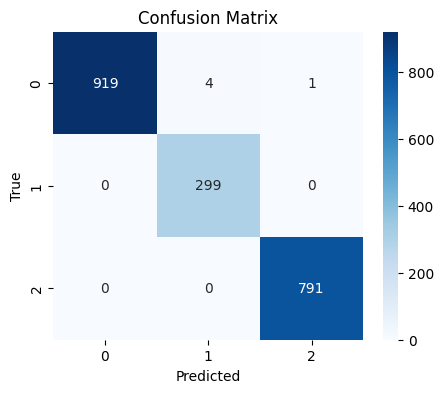

Average inference time per sample: 0.0944 ms


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time

# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# inference latency measurement
start_time = time.time()
_ = model.predict(X_test, verbose=0)
end_time = time.time()
latency_per_sample = (end_time - start_time) / X_test.shape[0]
print(f"Average inference time per sample: {latency_per_sample*1000:.4f} ms")

### **Interpretability with Random Forest feature importance**

Top 10 Important Features from Deep Embeddings:
   Feature_Index  Importance
0              8    0.110081
1             27    0.071104
2             55    0.068179
3             63    0.051977
4             30    0.051949
5             59    0.045345
6              4    0.045285
7             31    0.043243
8             20    0.026931
9             45    0.026042


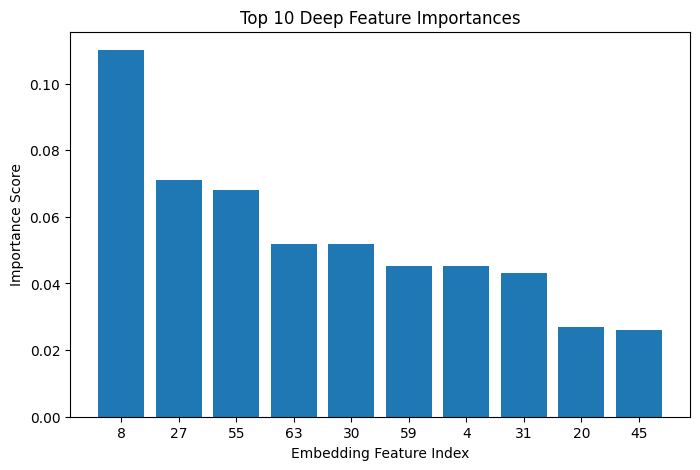

In [9]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# create a feature extractor model (remove the final Dense softmax layer)
feature_extractor = Model(inputs=model.input, outputs=model.layers[-4].output)

# extract features for train and test sets
X_train_features = feature_extractor.predict(X_train, verbose=0)
X_test_features = feature_extractor.predict(X_test, verbose=0)

# flatten if needed
if len(X_train_features.shape) > 2:
    X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# train a random forest on extracted features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, np.argmax(y_train, axis=1))

# get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# create table
importance_df = pd.DataFrame({
    'Feature_Index': indices,
    'Importance': importances[indices]
})

print("Top 10 Important Features from Deep Embeddings:")
print(importance_df.head(10))

# plot feature importances
plt.figure(figsize=(8,5))
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), indices[:10])
plt.xlabel('Embedding Feature Index')
plt.ylabel('Importance Score')
plt.title('Top 10 Deep Feature Importances')
plt.show()

## **Map Deep Embedding Features to Original Features**

Top 10 Important Original Features:
         Original_Feature  Importance
0     bwd_packets_IAT_min    0.062413
1     bwd_packets_IAT_max    0.051966
2    bwd_packets_IAT_mean    0.049930
3   bwd_packets_IAT_total    0.046250
4        fwd_packets_rate    0.042142
5  bwd_packets_IAT_median    0.040363
6    bwd_packets_IAT_mode    0.034145
7    bwd_segment_size_cov    0.033618
8      fwd_init_win_bytes    0.024424
9   segment_size_variance    0.023297


/tmp/ipython-input-4008132673.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Original_Feature', data=orig_importance_df.head(10), palette='viridis')


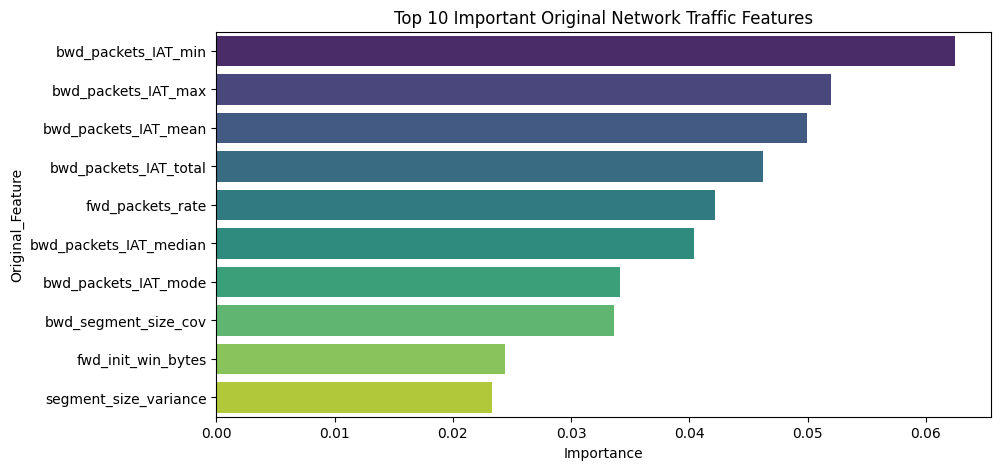

In [10]:
# Train RF directly on original scaled features
rf_orig = RandomForestClassifier(n_estimators=100, random_state=42)
rf_orig.fit(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1))

# Get importance scores for original features
orig_importances = rf_orig.feature_importances_
orig_indices = np.argsort(orig_importances)[::-1]

# Create dataframe for top features
orig_importance_df = pd.DataFrame({
    'Original_Feature': X.columns[orig_indices],
    'Importance': orig_importances[orig_indices]
})

print("Top 10 Important Original Features:")
print(orig_importance_df.head(10))

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Original_Feature', data=orig_importance_df.head(10), palette='viridis')
plt.title("Top 10 Important Original Network Traffic Features")
plt.show()